In [1]:
using Revise

In [2]:
using PyCall, PyPlot, Statistics
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

In [3]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting

In [4]:
using Random
using Distributions
using Interpolations
Random.seed!(11);

## Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [5]:
params = deepcopy(ClimateMARGO.IO.included_configurations["default"])
params.economics.ρ = 0.04
params.economics.mitigate_cost *= 1.5
model = ClimateModel(params)

max_deployment = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>0., "adapt"=>0.)
@time optimize_controls!(model, obj_option = "net_benefit", max_deployment=max_deployment);
base = deepcopy(model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Solve_Succeeded
 25.649725 seconds (58.10 M allocations: 3.065 GiB, 4.66% gc time, 99.76% compilation time)


In [6]:
N = 20000;

### CMIP6 (Uncertain) Distribution

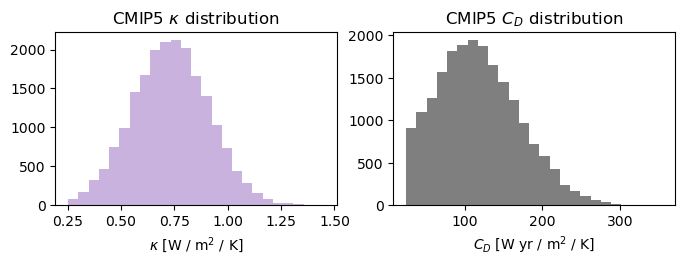

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/hdrake/.julia/packages/PyCall/BD546/src/numpy.jl:67


In [7]:
# Set parameter distributions
κ_μ = 0.73
κ_σ = 0.18
κ_min = 0.5 / 2 # half of minimum model
κ_dist = Normal(κ_μ, κ_σ);

Cd_μ = 106
Cd_σ = 62
Cd_min = 50. / 2 # half of minimum model
Cd_dist = Normal(Cd_μ, Cd_σ);

# Sample distribution (and shave off unphysical values)
κs = rand(κ_dist, N*2);
κs = κs[κs .> κ_min][1:N];
Cds = rand(Cd_dist, N*2);
Cds = Cds[Cds .> Cd_min][1:N];

# Plot parameter distributions
figure(figsize=(8,2.25))
subplot(1,2,1)
hist(κs, bins=25, alpha=0.5, color="C4");
title(L"CMIP5 $\kappa$ distribution")
xlabel(L"$\kappa$ [W / m$^{2}$ / K]")

subplot(1,2,2)
hist(Cds, bins=25, alpha=0.5, color="k");
title(L"CMIP5 $C_{D}$ distribution")
xlabel(L"$C_{D}$ [W yr / m$^{2}$ / K]")

uncertain = Array{ClimateModel, 1}(undef, (N,));
for i in 1:N
    model = deepcopy(base)
    model.physics.Cd = Cds[i]
    model.physics.κ = κs[i]
    optimize_controls!(model, obj_option = "net_benefit", max_deployment=max_deployment, print_raw_status=false);
    uncertain[i] = model
end
savefig("figures/mixing_parameter_distributions.png", bbox_inches="tight")

### Optimistic (half-uncertainty) distribution

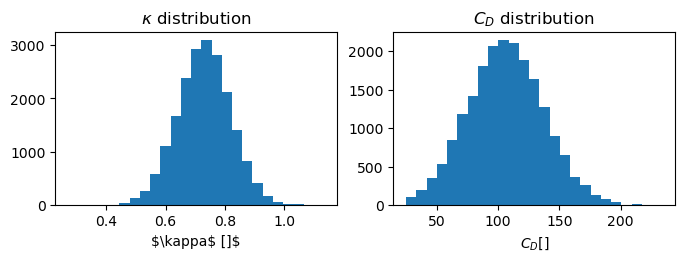

In [8]:
κ_dist_certain = Normal(κ_μ, κ_σ/2.);
Cd_dist_certain = Normal(Cd_μ, Cd_σ/2.);

# Sample distribution (and shave off unphysical values)
κs_certain = rand(κ_dist_certain, N*2);
κs_certain = κs_certain[κs_certain .> κ_min][1:N];
Cds_certain = rand(Cd_dist_certain, N*2);
Cds_certain = Cds_certain[Cds_certain .> Cd_min][1:N];

# Plot parameter distributions
figure(figsize=(8,2.25))
subplot(1,2,1)
hist(κs_certain, bins=25);
title(L"$\kappa$ distribution")
xlabel(L"$\kappa$ []$")

subplot(1,2,2)
hist(Cds_certain, bins=25);
title(L"$C_{D}$ distribution")
xlabel(L"$C_{D} []$")

certain = Array{ClimateModel, 1}(undef, (N,));
for i in 1:N
    model = deepcopy(base)
    model.physics.Cd = Cds_certain[i]
    model.physics.κ = κs_certain[i]
    optimize_controls!(model, obj_option = "net_benefit", max_deployment=max_deployment, print_raw_status=false);
    certain[i] = model
end

### Helper functions

In [9]:
function apply_func(ensemble::Array{ClimateModel}, func::Function; args...)
    tmp = func(rand(ensemble); args...)
    diag_arr = zeros(Float64, (length(ensemble), size(tmp)...))
    for (i, m) in enumerate(ensemble)
        selectdim(diag_arr, 1, i) .= func(m; args...)
    end
    
    return diag_arr
end

apply_func (generic function with 1 method)

## Deterministic baseline scenario

In [10]:
function init_plot()
    figure(figsize=(10.75, 3.5))
    for i=1:2
        subplot(1,2,i)
        xlabel("year")
        xlim(t(base)[1], t(base)[end])
        grid(true, alpha=0.2)
    end
end;

In [11]:
function plot_baselines(;add_labels=true)
    init_plot()
    subplot(1,2,1)
    ylabel(L"CO$_{2}$ emissions [ppm / year]");
    plot(t(base), zeros(size(t(base))), "--", color="darkgray")
    label = "~Extended RCP7.5"
    if ~add_labels
        label=nothing
    end
    plot(t(base), emissions(base), "k", label=label);
    ylim(-5, 27.5)
    if add_labels
        legend();
    end

    subplot(1,2,2)
    ylabel(L"global warming $T$ [$\degree$C]");
    label = "mean CMIP6 parameters"
    if ~add_labels
        label=nothing
    end
    plot(t(base), T(base), "k", label=label);
    ylim(0, 6)
    if add_labels
        legend();
    end
end;

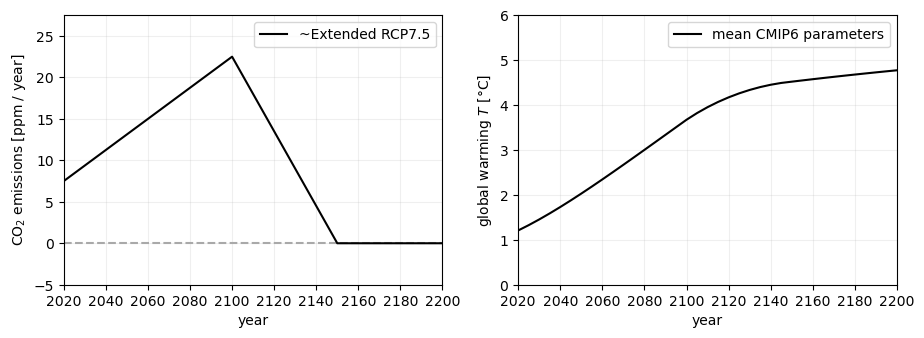

In [12]:
plot_baselines();
savefig("figures/0_baselines.png", dpi=150, bbox_inches="tight")

### Deterministic policy optimization

In [13]:
function add_mean_optimal();
    subplot(1,2,1)
    plot(t(base), effective_emissions(base, M=true, R=true)/base.physics.r, "C4", lw=2, label="Most 'beneficial' policy");
    legend(loc="upper right", fontsize=9);

    subplot(1,2,2)
    plot(t(base), T(base, M=true, R=true), "C4", label="Most 'beneficial' warming");
    legend(loc="upper left", fontsize=9);
end;

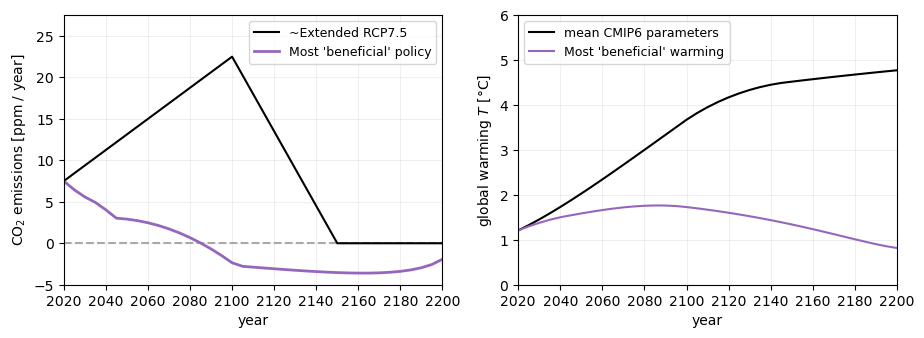

In [14]:
plot_baselines();
add_mean_optimal();
savefig("figures/1_deterministic.png", dpi=150, bbox_inches="tight")

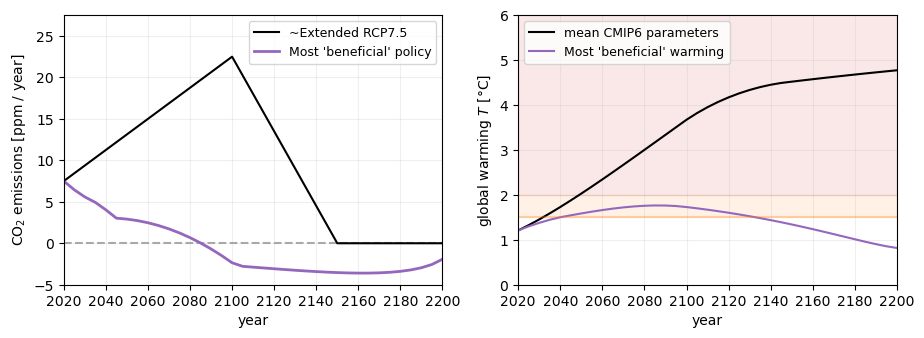

In [15]:
plot_baselines();
add_mean_optimal();
subplot(1,2,2)
fill_between(t(base), 2*ones(size(t(base))), 10*ones(size(t(base))), color="C3", alpha=0.1)
fill_between(t(base), 1.5*ones(size(t(base))), 2*ones(size(t(base))), color="C1", alpha=0.1)
plot(t(base), 1.5*ones(size(t(base))), color="C1", alpha=0.3)
savefig("figures/2_deterministic_goals.png", dpi=150, bbox_inches="tight")

### Including uncertainty in ocean mixing parameters

In [16]:
myquantile(arr) = quantile(arr, [0.05, 0.95]);

In [17]:
Tarr_baseline = apply_func(uncertain, T)
Tμ_baseline = mean(Tarr_baseline, dims=1)[:]
Tq_baseline = hcat(map(myquantile, (Tarr_baseline[:,j] for j=1:size(t(base),1)))...)
Tq05_baseline = Tq_baseline[1,:]
Tq95_baseline = Tq_baseline[2,:]
Tq50_baseline = median(Tarr_baseline, dims=1)[:];

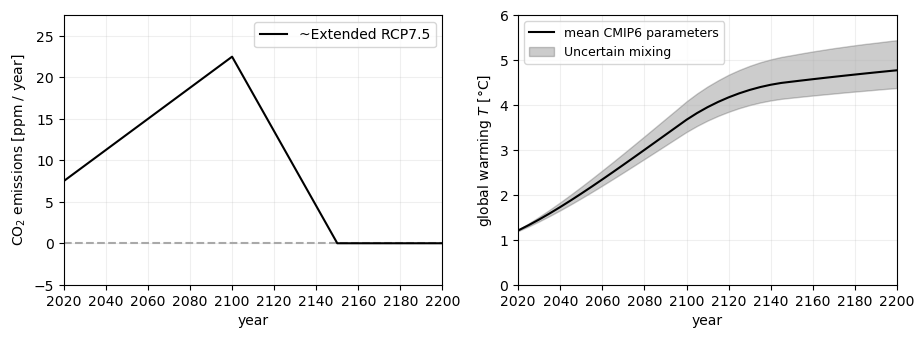

In [18]:
plot_baselines();

subplot(1,2,2)
fill_between(t(base), Tq05_baseline, Tq95_baseline, color="k", alpha=0.2, label="Uncertain mixing")
legend(loc="upper left", fontsize=9);
savefig("figures/3_probabalistic_baseline.png", dpi=150, bbox_inches="tight")

## The mean optimal policy

In [40]:
function net_emissions(m)
    return effective_emissions(m, M=true, R=true)/m.physics.r
end;

In [41]:
Tarr = apply_func(uncertain, T; M=true, R=true)
Tμ = mean(Tarr, dims=1)[:]
Tq = hcat(map(myquantile, (Tarr[:,j] for j=1:size(t(base),1)))...)
Tq05 = Tq[1,:]
Tq95 = Tq[2,:]
Tq50 = median(Tarr, dims=1)[:];

Earr = apply_func(uncertain, net_emissions)
Eμ = mean(Earr, dims=1)[:]
myquantile(Earr) = quantile(Earr, [0.05, 0.95])
Eq = hcat(map(myquantile, (Earr[:,j] for j=1:size(t(base),1)))...)
Eq05 = Eq[1,:]
Eq95 = Eq[2,:]
Eq50 = median(Earr, dims=1)[:];

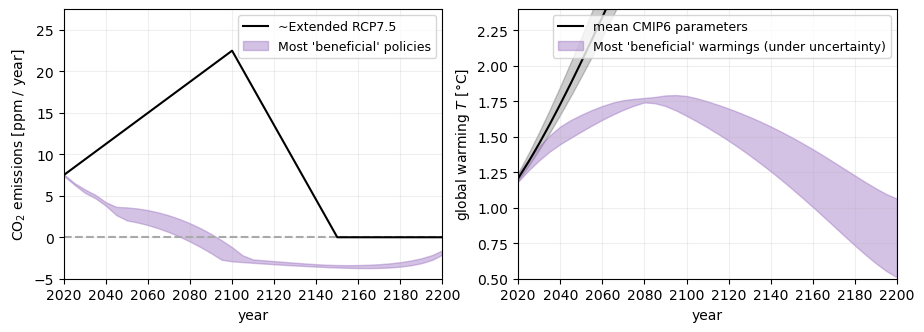

In [42]:
plot_baselines();

subplot(1,2,1)
fill_between(t(base), Eq05.-0.1, Eq95.+0.1, color="C4", alpha=0.4, label="Most 'beneficial' policies")
legend(loc="upper right", fontsize=9)

subplot(1,2,2)
fill_between(t(base), Tq05_baseline.-0.01, Tq95_baseline.+0.01, color="k", alpha=0.2)
fill_between(t(base), Tq05.-0.01, Tq95.+0.01, color="C4", alpha=0.4, label="Most 'beneficial' warmings (under uncertainty)")
legend(loc="upper right", fontsize=9);
ylim(0.5, 2.4);
savefig("figures/4_probabalistic_optimization.png", dpi=150, bbox_inches="tight")

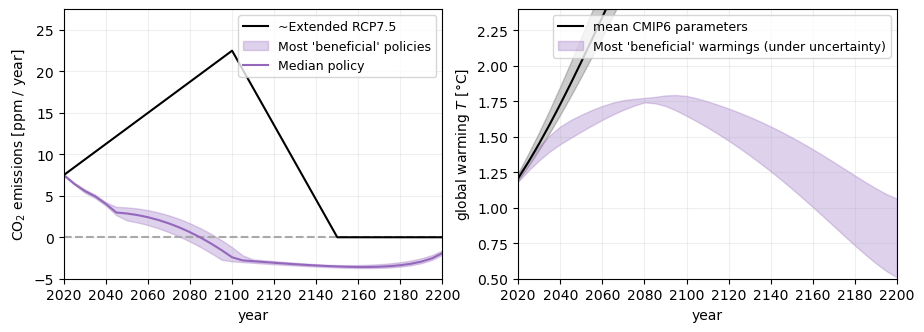

In [43]:
plot_baselines();

subplot(1,2,1)
fill_between(t(base), Eq05.-0.1, Eq95.+0.1, color="C4", alpha=0.3, label="Most 'beneficial' policies")
plot(t(base), Eq50, color="C4", label="Median policy")
legend(loc="upper right", fontsize=9)

subplot(1,2,2)
fill_between(t(base), Tq05_baseline.-0.01, Tq95_baseline.+0.01, color="k", alpha=0.2)
fill_between(t(base), Tq05.-0.01, Tq95.+0.01, color="C4", alpha=0.3, label="Most 'beneficial' warmings (under uncertainty)")
legend(loc="upper right", fontsize=9);
ylim(0.5, 2.4);
savefig("figures/5_median_policy.png", dpi=150, bbox_inches="tight")

In [44]:
function get_control(m; c=:mitigate)
    getfield(getfield(m, :controls), c)
end;

In [45]:
mean_policy_uncertain = deepcopy(uncertain)
for (i,m) in enumerate(mean_policy_uncertain)
    mean_policy_uncertain[i].controls.mitigate .= mean(apply_func(uncertain, get_control, c=:mitigate), dims=1)[:]
    mean_policy_uncertain[i].controls.remove .= mean(apply_func(uncertain, get_control, c=:remove), dims=1)[:]
end;

In [46]:
Tarr_unc = apply_func(mean_policy_uncertain, T; M=true, R=true)
Tμ_unc = mean(Tarr_unc, dims=1)[:]
Tq_unc = hcat(map(myquantile, (Tarr_unc[:,j] for j=1:size(t(base),1)))...)
Tq05_unc = Tq_unc[1,:]
Tq95_unc = Tq_unc[2,:]
Tq50_unc = median(Tarr_unc, dims=1)[:];

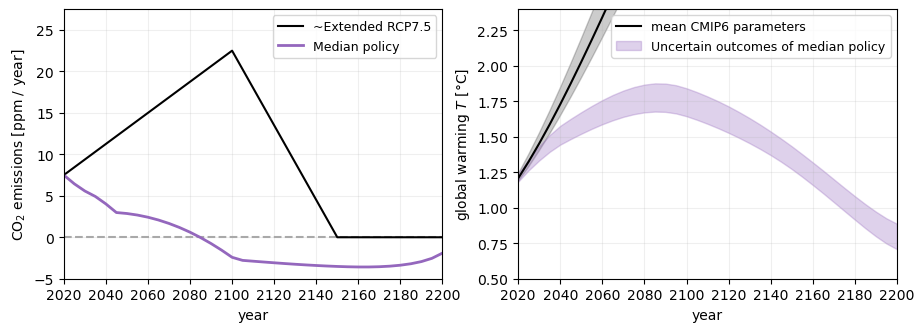

In [47]:
plot_baselines();

subplot(1,2,1)
plot(t(base), Eq50, color="C4", lw=2, label="Median policy")
legend(loc="upper right", fontsize=9)

subplot(1,2,2)
fill_between(t(base), Tq05_baseline.-0.01, Tq95_baseline.+0.01, color="k", alpha=0.2)
fill_between(t(base), Tq05_unc.-0.01, Tq95_unc.+0.01, color="C4", alpha=0.3, label="Uncertain outcomes of median policy")
legend(loc="upper right", fontsize=9);
ylim(0.5, 2.4);
savefig("figures/6_median_policy_outcomes.png", dpi=150, bbox_inches="tight")

In [144]:
i = 4017
E_ex = apply_func(uncertain, net_emissions)[i,:];
T_ex = apply_func(uncertain, T; M=true, R=true)[i,:];
T_ex_mean = apply_func(mean_policy_uncertain, T; M=true, R=true)[i,:];

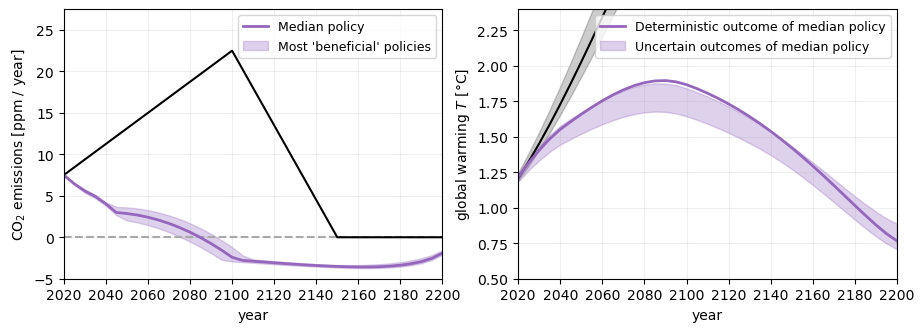

In [163]:
plot_baselines(add_labels=false);

subplot(1,2,1)
plot(t(base), Eq50, color="C4", lw=2, label="Median policy")
fill_between(t(base), Eq05.-0.1, Eq95.+0.1, color="C4", alpha=0.3, label="Most 'beneficial' policies")
legend(loc="upper right", fontsize=9)

subplot(1,2,2)
fill_between(t(base), Tq05_baseline.-0.01, Tq95_baseline.+0.01, color="k", alpha=0.2)
plot(t(base), T_ex_mean, color="C4", lw=2, label="Deterministic outcome of median policy")
fill_between(t(base), Tq05_unc.-0.01, Tq95_unc.+0.01, color="C4", alpha=0.3, label="Uncertain outcomes of median policy")
legend(loc="upper right", fontsize=9);
ylim(0.5, 2.4);
savefig("figures/7_median_policy_deterministic_outcome.png", dpi=150, bbox_inches="tight")

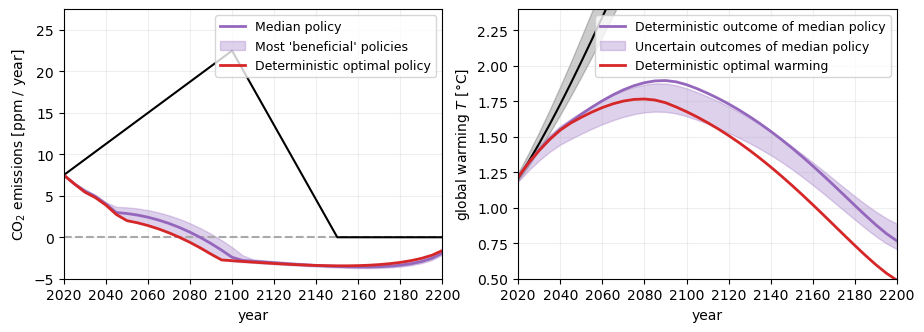

In [164]:
plot_baselines(add_labels=false);

subplot(1,2,1)
plot(t(base), Eq50, color="C4", lw=2, label="Median policy")
fill_between(t(base), Eq05.-0.1, Eq95.+0.1, color="C4", alpha=0.3, label="Most 'beneficial' policies")
plot(t(base), E_ex, color="C3", lw=2, label="Deterministic optimal policy")
legend(loc="upper right", fontsize=9)

subplot(1,2,2)
fill_between(t(base), Tq05_baseline.-0.01, Tq95_baseline.+0.01, color="k", alpha=0.2)
plot(t(base), T_ex_mean, color="C4", lw=2, label="Deterministic outcome of median policy")
fill_between(t(base), Tq05_unc.-0.01, Tq95_unc.+0.01, color="C4", alpha=0.3, label="Uncertain outcomes of median policy")
plot(t(base), T_ex, color="C3", lw=2, label="Deterministic optimal warming")
legend(loc="upper right", fontsize=9);
ylim(0.5, 2.4);
savefig("figures/8_deterministic_policy_error.png", dpi=150, bbox_inches="tight")

In [165]:
function npv(m)
    return net_present_benefit(m, M=true, R=true)
end;

In [166]:
mean_policy_certain = deepcopy(certain)
for (i,m) in enumerate(mean_policy_certain)
    mean_policy_certain[i].controls.mitigate .= mean_policy_uncertain[i].controls.mitigate
    mean_policy_certain[i].controls.remove .= mean_policy_uncertain[i].controls.remove
end;

In [167]:
Δnpv_uncertain = apply_func(mean_policy_uncertain, npv) - apply_func(uncertain, npv);
Δnpv_certain = apply_func(mean_policy_certain, npv) - apply_func(certain, npv);

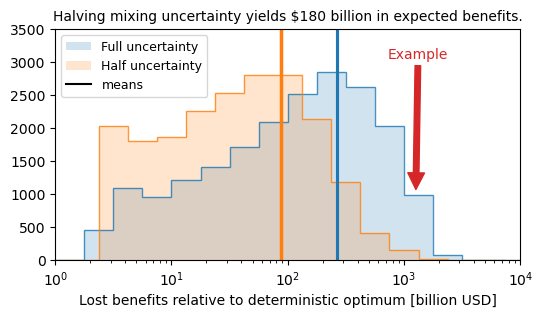

In [170]:
figure(figsize=(6,3))

dbin = 0.25
hist(-Δnpv_uncertain * 1e3, 10 .^(-1:dbin:4), color="C0", alpha=0.2, label="Full uncertainty", histtype="bar")
hist(-Δnpv_certain * 1e3, 10 .^(-1-dbin/2:dbin:4), color="C1", alpha=0.2, label="Half uncertainty", histtype="bar")
hist(-Δnpv_uncertain * 1e3, 10 .^(-1:dbin:4), color="C0", alpha=0.8, histtype="step")
hist(-Δnpv_certain * 1e3, 10 .^(-1-dbin/2:dbin:4), color="C1", alpha=0.8, histtype="step")
axvline(mean(-Δnpv_uncertain) * 1e3, lw=2.25, color="C0")
axvline(mean(-Δnpv_certain) * 1e3, lw=2.5, color="C1")
plot([],[],"k-", label="means")
xscale("log")
xlim(1, 1e4)
legend(fontsize=9)
xlabel("Lost benefits relative to deterministic optimum [billion USD]", fontsize=10)
ylim(0, 3500)

annotate(
    "Example", xy=(-Δnpv_uncertain[i,:] * 1e3, 1050),  xycoords="data",
    xytext=(0.78, 0.92), textcoords="axes fraction", color="C3",
    arrowprops=Dict("color"=>"C3", "shrink"=>0.01),
    horizontalalignment="center", verticalalignment="top",
)
title(string("Halving mixing uncertainty yields \$",Int64(round((mean(Δnpv_certain) - mean(Δnpv_uncertain)) * 1000, digits=-1))," billion in expected benefits."), fontsize=10)
savefig("figures/9_benefits_of_reducing_uncertainty.png", dpi=150, bbox_inches="tight")

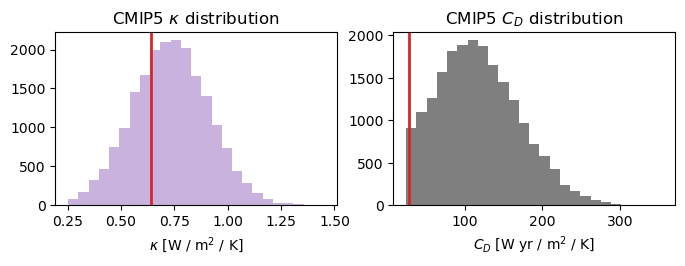

In [169]:
# Plot parameter distributions
figure(figsize=(8,2.25))
subplot(1,2,1)
hist(κs, bins=25, alpha=0.5, color="C4");
title(L"CMIP5 $\kappa$ distribution")
xlabel(L"$\kappa$ [W / m$^{2}$ / K]")
axvline(κs[i], color="C3", lw=2.)

subplot(1,2,2)
hist(Cds, bins=25, alpha=0.5, color="k");
title(L"CMIP5 $C_{D}$ distribution")
xlabel(L"$C_{D}$ [W yr / m$^{2}$ / K]")
axvline(Cds[i], color="C3", lw=2.)

savefig("figures/mixing_parameter_distributions_example.png", bbox_inches="tight")

# END

In [ ]:
cdr = apply_func(ensemble, get_removals)

In [ ]:
function netzero_year(m)
    itp = interpolate( (collect(t(m)),), effective_emissions(m, M=true, R=true) , Gridded(Linear()))
    t_annual = t(m)[1]:1.:t(m)[end]
    return t_annual[ itp(t_annual) .<= 0. ][1]
end

In [ ]:
function get_max_removal(m)
    maximum(getfield(getfield(m, :controls), :remove))
end

In [ ]:
function get_removals(m)
    getfield(getfield(m, :controls), :remove)
end

In [ ]:
hist(apply_func(ensemble, get_max_removal))

In [ ]:
apply_func(ensemble, netzero_year))

In [ ]:
hist(apply_func(ensemble, netzero_year))

In [ ]:
figure(figsize=(16, 4))

subplot(1,4,1)
grid(true, alpha=0.1)
for i = 1:N
    m = ensemble[i]
    plot(t(m), T(m), alpha=0.1, color="C0")
end

ylim(1, 6)
xlim(2020, 2200)

subplot(1,4,2)
grid(true, alpha=0.1)
for i = 1:N
    model = deepcopy(base)
    model.physics.Cd = Cds[i]
    model.physics.κ = κs[i]
    optimize_controls!(model, obj_option = "adaptive_temp", temp_goal = 1.5, overshoot_year=2150., temp_overshoot = 2, print_raw_status=false, max_deployment=max_deployment);
    plot(t(model), T(model, M=true, R=true), alpha=0.1, color="C0")
end
xlim(2020, 2200)

subplot(1,4,3)
grid(true, alpha=0.1)
for i = 1:N
    model = deepcopy(base)
    model.physics.Cd = Cds[i]
    model.physics.κ = κs[i]
    optimize_controls!(model, obj_option = "adaptive_temp", temp_goal = 1.5, overshoot_year=2150., temp_overshoot = 2, print_raw_status=false, max_deployment=max_deployment);
    plot(t(model), model.controls.mitigate, alpha=0.1, color="C0")
    plot(t(model), model.controls.remove, alpha=0.1, color="C3")
end
ylim(0, 1.1)
xlim(2020, 2200)

subplot(1,4,4)
grid(true, alpha=0.1)
for i = 1:N
    model = deepcopy(base)
    model.physics.Cd = Cds[i]
    model.physics.κ = κs[i]
    optimize_controls!(model, obj_option = "adaptive_temp", temp_goal = 1.5, overshoot_year=2150., temp_overshoot = 2, print_raw_status=false, max_deployment=max_deployment);
    plot(t(model), effective_emissions(model, M=true, R=true)/model.physics.r, alpha=0.1, color="k")
end
xlim(2020, 2200)

In [ ]:
figure(figsize=(16, 4))

subplot(1,4,1)
grid(true, alpha=0.1)
for i = 1:N
    model = deepcopy(base)
    model.physics.Cd = Cds[i]
    model.physics.κ = κs[i]
    plot(t(model), T(model), alpha=0.1, color="C0")
end

ylim(1, 6)
xlim(2020, 2200)

subplot(1,4,2)
grid(true, alpha=0.1)
for i = 1:N
    model = deepcopy(base)
    model.physics.Cd = Cds[i]
    model.physics.κ = κs[i]
    optimize_controls!(model, obj_option="net_benefit", print_raw_status=false, max_deployment=max_deployment);
    plot(t(model), T(model, M=true, R=true), alpha=0.1, color="C0")
end
xlim(2020, 2200)

subplot(1,4,3)
grid(true, alpha=0.1)
for i = 1:N
    model = deepcopy(base)
    model.physics.Cd = Cds[i]
    model.physics.κ = κs[i]
    optimize_controls!(model, obj_option="net_benefit", print_raw_status=false, max_deployment=max_deployment);
    plot(t(model), model.controls.mitigate, alpha=0.1, color="C0")
    plot(t(model), model.controls.remove, alpha=0.1, color="C3")
end
ylim(0, 1.1)
xlim(2020, 2200)

subplot(1,4,4)
grid(true, alpha=0.1)
for i = 1:N
    model = deepcopy(base)
    model.physics.Cd = Cds[i]
    model.physics.κ = κs[i]
    optimize_controls!(model, obj_option="net_benefit", print_raw_status=false, max_deployment=max_deployment);
    plot(t(model), effective_emissions(model, M=true, R=true)/model.physics.r, alpha=0.1, color="k")
end
xlim(2020, 2200)